# Settings

In [1]:
import sys

# set lib path just next to current path to give priority to modules in lib
sys.path.insert(sys.path.index('')+1, '/lib')

In [2]:
%load_ext autotime

import pandas as pd
import FinanceDataReader as fdr

from lib.fastquant import backtest_portfolio
from lib.utils import HiddenPrints, DATE_FORMAT
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np

time: 13.4 s (started: 2023-02-28 07:52:38 +09:00)


In [3]:
def run_backtest(start, df_bt, kwargs, proba=1, strategy='custom'):
    
    df = df_bt.copy()
    end = start + timedelta(hold_period)
    df = df.loc[start:end]
    if proba < 1:
        df.loc[:,'custom'] = df.custom.apply(lambda x:x*np.random.choice(2, 1, p=[1.-proba, proba])[0])
    df = {symbol: df}
    with HiddenPrints(mark_end=False):
        result = backtest_portfolio(strategy, df, start.strftime(DATE_FORMAT), end.strftime(DATE_FORMAT), **kwargs)
    #return result # testing
        
    #if np.isnan(result['history']['win_rate'].squeeze()):
    if result['history']['len'].squeeze() == 0:
        #return [start, end, None, None, None] # last col 'return' cast to NaT instead of None 
        return [start, end, -1, None, None]
    else:
        return [start, end] + result['summary']
    

def print_progress(i, print_step, last_print):
    n = round((i+1) / n_dates * 100)
    if n != last_print and n % (print_step*100) == 0:
        print(f'{n}% done')
        return n
    else:
        return last_print

time: 2.14 ms (started: 2023-02-28 07:53:09 +09:00)


In [3]:
start = '20180101'
end = '20221231'

symbol = '069500' # KODEX 200
df_all = fdr.DataReader(symbol, start, end)

time: 294 ms (started: 2023-02-27 22:31:12 +09:00)


In [5]:
df_compare = pd.DataFrame()

time: 1.57 ms (started: 2023-02-27 22:31:12 +09:00)


# Buy & hold

## Settings

In [6]:
df_bt = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt.index

time: 7.12 ms (started: 2023-02-23 12:18:48 +09:00)


In [7]:
hold_period = 365
dates_start = df_bt.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 7.68 ms (started: 2023-02-23 12:18:49 +09:00)


In [8]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 7.1 ms (started: 2023-02-23 12:18:49 +09:00)


In [9]:
# testing
#dates_start = dates_start[:50]

time: 6.51 ms (started: 2023-02-23 12:18:50 +09:00)


## SC01

In [10]:
scenario = 'b1'
n_buy = 1

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1e+03 µs (started: 2023-02-23 12:18:51 +09:00)


In [11]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    df_bt.loc[start,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 13min 6s (started: 2023-02-23 12:18:52 +09:00)


In [12]:
df_result['return'].agg(['mean','min','max'])

mean      6.723509
min     -29.578320
max     111.056006
Name: return, dtype: float64

time: 19.3 ms (started: 2023-02-23 12:31:58 +09:00)


In [13]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 10.9 ms (started: 2023-02-23 12:31:58 +09:00)


## SC02

In [14]:
scenario = 'b2'
n_buy = 10

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 7.29 ms (started: 2023-02-23 12:32:42 +09:00)


In [15]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 20

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 14min (started: 2023-02-23 12:32:45 +09:00)


In [16]:
df_result['return'].agg(['mean','min','max'])

mean     2.625810
min    -16.512425
max     38.402674
Name: return, dtype: float64

time: 21.3 ms (started: 2023-02-23 12:46:46 +09:00)


In [17]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 22.4 ms (started: 2023-02-23 12:46:46 +09:00)


## SC03

In [18]:
scenario = 'b3'
n_buy = 20

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.06 ms (started: 2023-02-23 12:46:46 +09:00)


In [19]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 10

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 15min 10s (started: 2023-02-23 12:46:46 +09:00)


In [20]:
df_result['return'].agg(['mean','min','max'])

mean     2.453650
min    -16.298809
max     36.055343
Name: return, dtype: float64

time: 21 ms (started: 2023-02-23 13:01:56 +09:00)


In [21]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 18.3 ms (started: 2023-02-23 13:01:56 +09:00)


## Compare

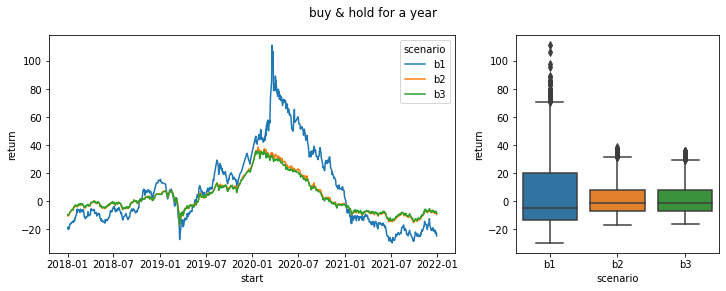

time: 1.35 s (started: 2023-02-23 13:01:56 +09:00)


In [23]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

df = df_compare.dropna(subset='return').reset_index()
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1)
_ = sns.boxplot(data=df, x='scenario', y='return', ax=ax2)

# Technical Indicator

## Settings

In [24]:
import tulipy as ti

time: 17.2 ms (started: 2023-02-23 13:02:30 +09:00)


In [25]:
def calc_macd(df, periods=[12,26,9]):
    ind = ti.macd(df.astype(float).to_numpy(), *periods)

    name = 'macd'
    cols = [name, name+'_signal', name+'_histogram']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def calc_bbands(df, periods=[20,2]):
    ind = ti.bbands(df.astype(float).to_numpy(), *periods)

    name = 'bbands'
    cols = [name+'_lower', name+'_middle', name+'_upper']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def finish_custom(df_bt):
    df = df_bt.copy()
    prv = 0
    for dt, (_, c) in df.iterrows():
        if c in [1, -1]:
            if c == prv:
                df.loc[dt, 'custom'] = 0
            else:
                prv = c
        else:
            prv = 0
    return df


def check_scenario(idx_nobuy, i=None, df_result=None):
    if df_result is None:
        n = len(idx_nobuy)
        if n > 0:
            print(f'{n} scenarios of no buy.')
        return None
    if pd.isnull(df_result.loc[i]['return']):
        idx_nobuy.append(i)
        n = len(idx_nobuy)
        if n < 2:
            print(f'{i}: No buy at all')
        elif n == 2:
            print('there are more scenarios of no buy.')
        else:
            pass
    return idx_nobuy

time: 3.78 ms (started: 2023-02-23 13:02:31 +09:00)


In [75]:
df_bt_ori = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt_ori.index

time: 12.9 ms (started: 2023-02-23 14:48:52 +09:00)


In [76]:
hold_period = 365
dates_start = df_bt_ori.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 3.03 ms (started: 2023-02-23 14:48:53 +09:00)


In [31]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 1.08 ms (started: 2023-02-23 13:02:54 +09:00)


In [32]:
# testing
#dates_start = dates_start[400:500]

time: 642 µs (started: 2023-02-23 13:02:55 +09:00)


## SC01: MACD

### calc tech indi

In [78]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])

time: 10.6 ms (started: 2023-02-23 14:49:23 +09:00)


In [34]:
df_ti = df_macd

cond = (df_ti.macd > df_ti.macd_signal) 
cond = cond & (df_ti.macd > 0)
df_bt.loc[cond, 'custom'] = -1

cond = (df_ti.macd < df_ti.macd_signal) 
cond = cond & (df_ti.macd < 0)
df_bt.loc[cond, 'custom'] = 1

time: 11.8 ms (started: 2023-02-23 13:02:57 +09:00)


In [35]:
df_bt = finish_custom(df_bt)

time: 373 ms (started: 2023-02-23 13:02:58 +09:00)


In [36]:
# small number of chance to buy
df_bt.custom.value_counts()

 0    1161
 1      38
-1      33
Name: custom, dtype: int64

time: 10.4 ms (started: 2023-02-23 13:02:58 +09:00)


### bactesting 1

In [37]:
scenario = 't1a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 990 µs (started: 2023-02-23 13:03:02 +09:00)


In [39]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
20 % done
255: No buy at all
there are more scenarios of no buy.
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
40 scenarios of no buy.
time: 16min 39s (started: 2023-02-23 13:03:52 +09:00)


In [40]:
df_result['return'].agg(['mean','min','max'])

mean     7.291352
min    -12.013608
max     57.532363
Name: return, dtype: float64

time: 14.3 ms (started: 2023-02-23 13:20:32 +09:00)


In [41]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 15.4 ms (started: 2023-02-23 13:20:32 +09:00)


### bactesting 2

In [42]:
scenario = 't1b'

kwargs_bt.update({
    'buy_prop': 0.5,
    'sell_prop': 0.5
})

time: 1.01 ms (started: 2023-02-23 13:20:32 +09:00)


In [43]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
20 % done
258: No buy at all
30 % done
there are more scenarios of no buy.
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
33 scenarios of no buy.
time: 18min 49s (started: 2023-02-23 13:20:32 +09:00)


In [44]:
df_result['return'].agg(['mean','min','max'])

mean     4.238674
min     -6.153420
max     36.403294
Name: return, dtype: float64

time: 14.5 ms (started: 2023-02-23 13:39:21 +09:00)


In [45]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13.7 ms (started: 2023-02-23 13:39:21 +09:00)


### bactesting 3

In [46]:
scenario = 't1c'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

time: 1.15 ms (started: 2023-02-23 13:39:21 +09:00)


In [47]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
20 % done
213: No buy at all
there are more scenarios of no buy.
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
25 scenarios of no buy.
time: 21min 46s (started: 2023-02-23 13:39:21 +09:00)


In [48]:
df_result['return'].agg(['mean','min','max'])

mean     1.731516
min     -3.162596
max     16.136710
Name: return, dtype: float64

time: 15.9 ms (started: 2023-02-23 14:01:08 +09:00)


In [49]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 12.3 ms (started: 2023-02-23 14:01:08 +09:00)


### bactesting 4

In [60]:
scenario = 't1d'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

proba = 0.8

time: 1.21 ms (started: 2023-02-23 14:14:27 +09:00)


In [61]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt, proba)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

36: No buy at all
10 % done
20 % done
there are more scenarios of no buy.
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
42 scenarios of no buy.
time: 25min 38s (started: 2023-02-23 14:14:29 +09:00)


In [62]:
df_result['return'].agg(['mean','min','max'])

mean     6.535910
min    -18.098724
max     68.160862
Name: return, dtype: float64

time: 14.9 ms (started: 2023-02-23 14:40:08 +09:00)


In [63]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 16.4 ms (started: 2023-02-23 14:40:08 +09:00)


In [74]:
df_compare.to_csv('df_compare_5yrs.csv')

time: 224 ms (started: 2023-02-23 14:47:22 +09:00)


### compare

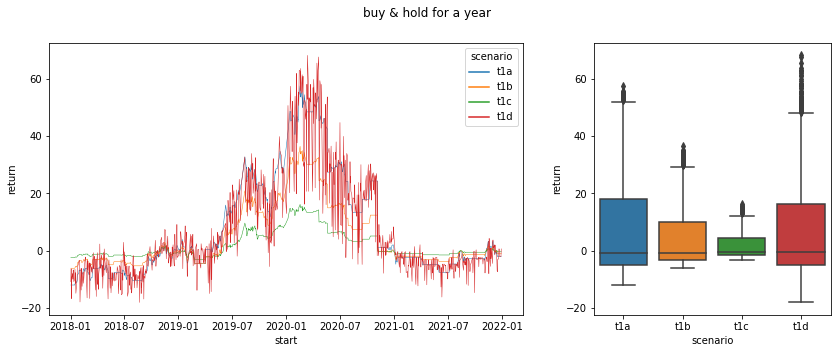

time: 1.39 s (started: 2023-02-23 17:23:01 +09:00)


In [105]:
fig = plt.figure(figsize=(14, 5))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
#fig.tight_layout()

df = (df_compare.loc[df_compare.scenario.str.startswith('t1')]
                .dropna(subset='return').reset_index())
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, x='scenario', y='return', ax=ax2)

## SC02: Bollinger Bands

### calc tech indi

In [79]:
df_bt = df_bt_ori.copy()
df_bbands = calc_bbands(df_bt['close'])
#df_bbands = calc_bbands(df_bt['close'], [20, 1])

time: 5.56 ms (started: 2023-02-23 14:49:34 +09:00)


In [80]:
df_ti = df_bbands

cond = df_bt.close < df_ti.bbands_lower
df_bt.loc[cond, 'custom'] = -1

cond = df_bt.close > df_ti.bbands_upper
df_bt.loc[cond, 'custom'] = 1

time: 8.15 ms (started: 2023-02-23 14:49:40 +09:00)


In [81]:
df_bt = finish_custom(df_bt)

time: 193 ms (started: 2023-02-23 14:49:42 +09:00)


In [82]:
df_bt.custom.value_counts()

 0    1157
-1      42
 1      33
Name: custom, dtype: int64

time: 18.3 ms (started: 2023-02-23 14:49:44 +09:00)


### bactesting 1

In [83]:
scenario = 't2a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 5.57 ms (started: 2023-02-23 14:50:05 +09:00)


In [84]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
107: No buy at all
there are more scenarios of no buy.
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
72 scenarios of no buy.
time: 29min 5s (started: 2023-02-23 14:50:07 +09:00)


In [85]:
df_result['return'].agg(['mean','min','max'])

mean    -2.072691
min    -25.756412
max     19.857751
Name: return, dtype: float64

time: 15.5 ms (started: 2023-02-23 15:19:12 +09:00)


In [86]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 11.4 ms (started: 2023-02-23 15:19:12 +09:00)


### bactesting 2

In [87]:
scenario = 't2b'

kwargs_bt.update({
    'buy_prop': 0.5,
    'sell_prop': 0.5
})

time: 1.03 ms (started: 2023-02-23 15:19:12 +09:00)


In [88]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
107: No buy at all
there are more scenarios of no buy.
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
79 scenarios of no buy.
time: 33min 50s (started: 2023-02-23 15:19:13 +09:00)


In [89]:
df_result['return'].agg(['mean','min','max'])

mean    -2.049049
min    -24.544178
max     13.797432
Name: return, dtype: float64

time: 12.8 ms (started: 2023-02-23 15:53:03 +09:00)


In [90]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13.9 ms (started: 2023-02-23 15:53:03 +09:00)


### bactesting 3

In [91]:
scenario = 't2c'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

time: 1.02 ms (started: 2023-02-23 15:53:03 +09:00)


In [92]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

62: No buy at all
there are more scenarios of no buy.
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
111 scenarios of no buy.
time: 38min 46s (started: 2023-02-23 15:53:04 +09:00)


In [93]:
df_result['return'].agg(['mean','min','max'])

mean    -1.976350
min    -20.921568
max      6.320392
Name: return, dtype: float64

time: 18.8 ms (started: 2023-02-23 16:31:50 +09:00)


In [94]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 22 ms (started: 2023-02-23 16:31:50 +09:00)


### bactesting 4

In [95]:
scenario = 't2d'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

proba = 0.5

time: 1.14 ms (started: 2023-02-23 16:31:50 +09:00)


In [96]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt, proba)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

17: No buy at all
there are more scenarios of no buy.
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
133 scenarios of no buy.
time: 45min (started: 2023-02-23 16:31:51 +09:00)


In [97]:
df_result['return'].agg(['mean','min','max'])

mean    -1.766146
min    -17.846510
max     10.629953
Name: return, dtype: float64

time: 19.8 ms (started: 2023-02-23 17:16:51 +09:00)


In [98]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 28.1 ms (started: 2023-02-23 17:16:51 +09:00)


In [99]:
df_compare.to_csv('df_compare_5yrs.csv')

time: 392 ms (started: 2023-02-23 17:17:40 +09:00)


### compare

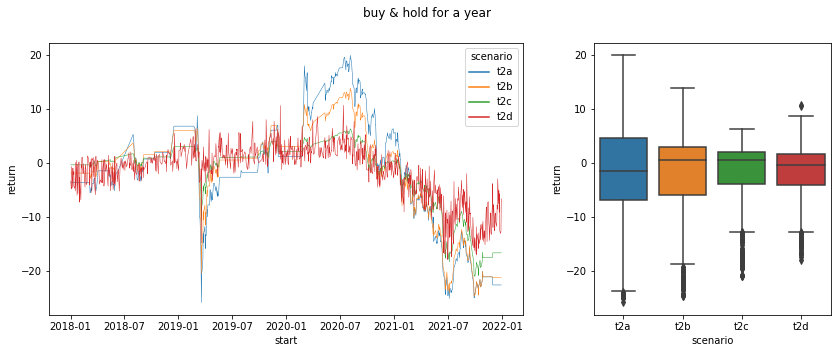

time: 1.36 s (started: 2023-02-23 17:21:49 +09:00)


In [104]:
fig = plt.figure(figsize=(14, 5))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
#fig.tight_layout()

df = (df_compare.loc[df_compare.scenario.str.startswith('t2')]
                .dropna(subset='return').reset_index())
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, x='scenario', y='return', ax=ax2)

## SC03: Bollinger Bands & MACD

### calc tech indi

In [106]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])
df_bbands = calc_bbands(df_bt['close'])

time: 11.1 ms (started: 2023-02-23 17:24:38 +09:00)


In [107]:
cond = (df_macd.macd > df_macd.macd_signal) & (df_macd.macd > 0)
cond = cond + (df_bt.close < df_bbands.bbands_lower)
df_bt.loc[cond, 'custom'] = -1

cond = (df_macd.macd < df_macd.macd_signal) & (df_macd.macd < 0)
cond = cond + (df_bt.close > df_bbands.bbands_lower)
df_bt.loc[cond, 'custom'] = 1

time: 14 ms (started: 2023-02-23 17:25:23 +09:00)


In [108]:
df_bt = finish_custom(df_bt)

time: 528 ms (started: 2023-02-23 17:25:29 +09:00)


In [109]:
df_bt.custom.value_counts()

 0    1207
 1      13
-1      12
Name: custom, dtype: int64

time: 20.7 ms (started: 2023-02-23 17:25:30 +09:00)


### bactesting

In [111]:
scenario = 't3'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 1.06 ms (started: 2023-02-23 17:26:47 +09:00)


In [112]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

26: No buy at all
there are more scenarios of no buy.
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
501 scenarios of no buy.
time: 51min 12s (started: 2023-02-23 17:26:51 +09:00)


In [113]:
df_result['return'].agg(['mean','min','max'])

mean    1.768180
min    -1.706558
max     5.116971
Name: return, dtype: float64

time: 45 ms (started: 2023-02-23 18:18:03 +09:00)


In [114]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 478 ms (started: 2023-02-23 18:18:03 +09:00)


In [144]:
df_compare.to_csv('df_compare_5yrs.csv')

time: 346 ms (started: 2023-02-23 18:50:56 +09:00)


# Comparison

In [4]:
df_compare = pd.read_csv('df_compare_5yrs.csv', index_col=0, parse_dates=['start'])
#df_compare

time: 40.2 ms (started: 2023-02-28 07:53:21 +09:00)


In [5]:
df_compare.groupby(by=['scenario']).agg(['mean','median','min','max','std','count'])

return                                                  
              mean    median        min         max        std count
scenario                                                            
b1        6.723509 -4.410756 -29.578320  111.056006  27.760491   931
b2        2.625810 -1.313716 -16.512425   38.402674  12.987301   923
b3        2.453650 -1.279150 -16.298809   36.055343  12.294943   921
t1a       7.291352 -0.666501 -12.013608   57.532364  17.581918   945
t1b       4.238674 -1.001026  -6.153420   36.403294  10.546404   952
t1c       1.731516 -0.565984  -3.162596   16.136710   4.682957   960
t1d       6.535910 -0.562195 -18.098724   68.160862  17.759968   943
t2a      -2.072691 -1.465398 -25.756412   19.857751  10.555794   913
t2b      -2.049049  0.534407 -24.544178   13.797432   9.210288   906
t2c      -1.976350  0.478720 -20.921568    6.320392   6.583703   874
t2d      -1.766146 -0.392498 -17.846510   10.629953   5.054592   852
t3        1.768180  1.218663  -1.706558    5.116971   2.173672   484

time: 82 ms (started: 2023-02-28 07:53:24 +09:00)


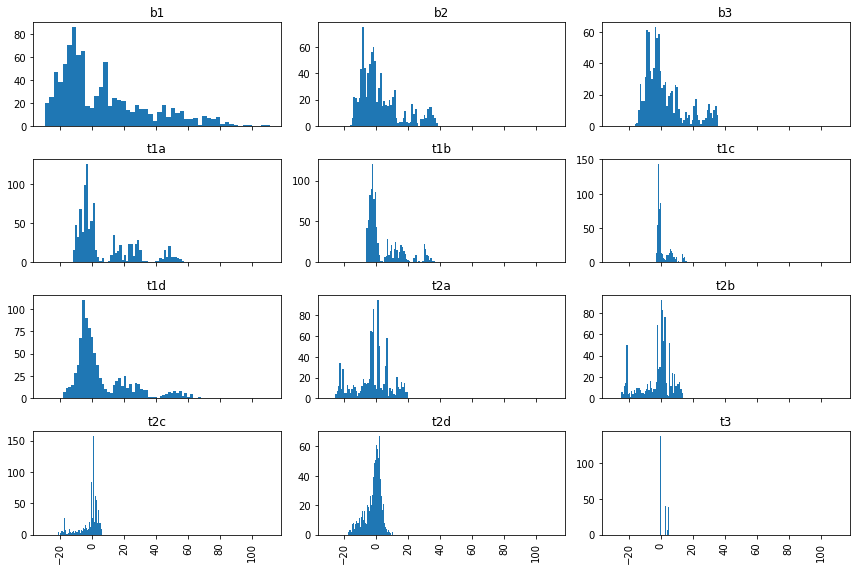

time: 7.31 s (started: 2023-02-27 22:33:42 +09:00)


In [10]:
_ = df_compare.hist(by='scenario', column='return', figsize=(12,8), bins=50, sharex=True)
plt.tight_layout()

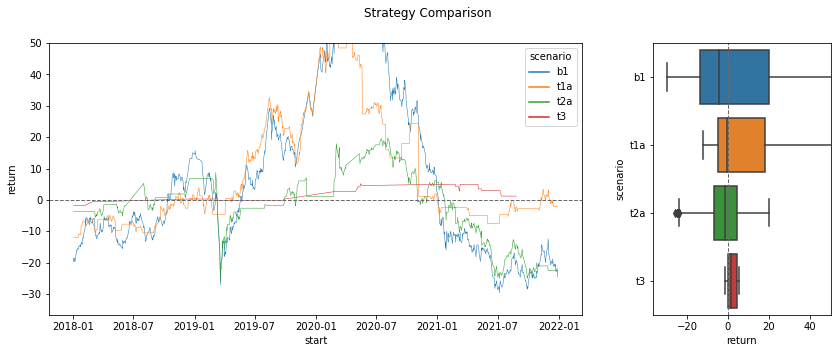

time: 1.46 s (started: 2023-02-23 20:27:31 +09:00)


In [165]:
ret_limit = 50
kw_axline = dict(lw=1, ls='--', c='dimgray')

fig = plt.figure(figsize=(14, 5))
fig.suptitle("Strategy Comparison")
gs = GridSpec(1, 2, width_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0])
#ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax2 = fig.add_subplot(gs[1])
#fig.tight_layout()

df = (df_compare
      #.loc[df_compare.scenario.str.startswith('t2')]
      .loc[df_compare.scenario.isin(['b1', 't1a', 't2a', 't3'])]
      .dropna(subset='return').reset_index()
)
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, y='scenario', x='return', ax=ax2,
                orient='h'
               )

_ = ax1.axhline(**kw_axline)
_ = ax2.axvline(**kw_axline)
_ = ax1.set_ylim(top=ret_limit)
_ = ax2.set_xlim(right=ret_limit)

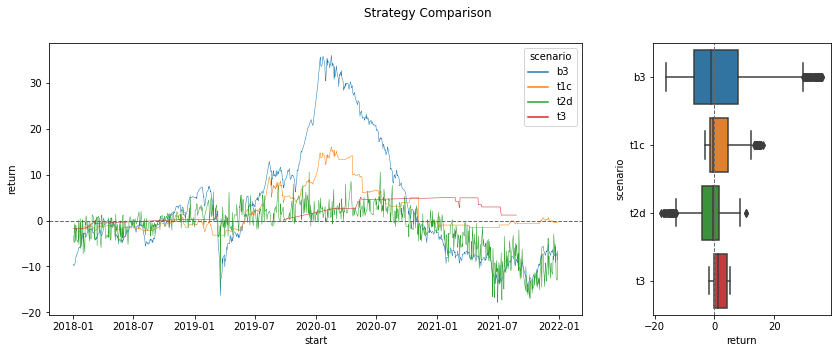

time: 1.42 s (started: 2023-02-23 20:58:09 +09:00)


In [167]:
ret_limit = None
kw_axline = dict(lw=1, ls='--', c='dimgray')

fig = plt.figure(figsize=(14, 5))
fig.suptitle("Strategy Comparison")
gs = GridSpec(1, 2, width_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0])
#ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax2 = fig.add_subplot(gs[1])
#fig.tight_layout()

df = (df_compare
      .loc[df_compare.scenario.isin(['b3', 't1c', 't2d', 't3'])]
      .dropna(subset='return').reset_index()
)
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, y='scenario', x='return', ax=ax2,
                orient='h'
               )

_ = ax1.axhline(**kw_axline)
_ = ax2.axvline(**kw_axline)
_ = ax1.set_ylim(top=ret_limit)
_ = ax2.set_xlim(right=ret_limit)

## Bayesian estimation

In [75]:
# TO DELETE

import pymc3 as pm
import arviz
from matplotlib import gridspec
from scipy import stats

YEAR = 252
midx = pd.IndexSlice
DATE_FILE = '%y%m%d'


    
def bayesian_estimate(df_returns, draws=10000, tune=2500, burnin=0,
                      chains=4, target_accept=.9, inspect_mode=False, 
                      figsize=(10, 14), loc_legend='upper right',
                      plot_trace=True, save_plot=False, save_path=None):
    """
    Bayesian hypothesis test to compare two return distributions. 
    Returns are assumed to be T-distributed.
    can run with more than 2 return dists but no comparison then
    """
    if not isinstance(df_returns, pd.Series):
        print('ERROR: df_returns is not series')
        return
    else:
        df_returns = df_returns.dropna()
        lvl1, _ = df_returns.index.names
        
    # priors
    mean_prior, std_prior = df_returns.mean(), df_returns.std()
    std_low, std_high = std_prior / 1000, std_prior * 1000
    T = YEAR ** .5
    mean, std, returns = {}, {}, {}
    groups = df_returns.index.get_level_values(lvl1).unique()
    num_groups = len(groups) # flag to plot comparisio if comparing two hists
    
    with pm.Model() as model:
        nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
        for i, g in enumerate(groups):
            df_g = df_returns.loc[midx[g]]
            mean[i] = pm.Normal(f'mean_{g}', mu=mean_prior, sd=std_prior, testval=df_g.mean())
            std[i] = pm.Uniform(f'std_{g}', lower=std_low, upper=std_high, testval=df_g.std())
            returns[i] = pm.StudentT(f'returns_{g}', nu=nu, mu=mean[i], sd=std[i], observed=df_g)
            pm.Deterministic(f'vol_{g}', returns[i].distribution.sd * T)
            pm.Deterministic(f'sharpe_{g}', returns[i].distribution.mean / returns[i].distribution.sd * T)
        if num_groups == 2:
            mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
            pm.Deterministic('std diff', std[0] - std[1])
            pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)

    if inspect_mode:
        pm.model_to_graphviz(model=model)

    with model:
        # HMC NUTS Sampling
        #cores, _ = print_machine_type()
        trace = pm.sample(draws=draws, tune=tune,
                          chains=chains, 
                          #cores=cores,
                          target_accept=target_accept,
                          #return_inferencedata=False, # TODO: what's for?
                          progressbar=True)
    #pm.trace_to_dataframe(trace).info()


    ### plot & compare
    # To compare the performance of two return series, we model each group’s Sharpe ratio separately 
    # and compute the effect size as the difference between the volatility-adjusted returns.
    plot_bayesian_returns(trace, groups, burnin, figsize, loc_legend, 
                                 save_plot, save_path)

    # TODO: implement
    #arviz.plot_forest(data=trace)

    if plot_trace:
        plot_traces(trace, burnin=burnin, fig_width=figsize[0])
        
    return (trace, groups)


def plot_bayesian_returns(trace, groups, 
                            burnin=0, figsize=(12, 16), loc_legend='upper right',
                            save=True, path=None):
    trace = trace[burnin:]
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    num_groups = len(groups)
    if num_groups == 2:
        cols = 2
    else:
        cols = 1
    gs = gridspec.GridSpec(4, cols, wspace=0.1, hspace=0.4)
    axs = [plt.subplot(gs[i, j]) for i in [0, 1, 2] for j in [0, 1]]
    axs.append(plt.subplot(gs[3, :]))
    vl_style = {'ls':'--', 'lw':0.7, 'c':'black',}
    
    kw_hist = dict(kde=True, stat="density", kde_kws=dict(cut=3), 
                   alpha=.4, edgecolor=(1, 1, 1, .4))

    def distplot_w_perc(trace, ax):
        #sns.distplot(trace, ax=ax)
        sns.histplot(trace, ax=ax, **kw_hist)
        ax.axvline(stats.scoreatpercentile(trace, 2.5), 
                   label='2.5 & 97.5\npercentiles', **vl_style)
        ax.axvline(stats.scoreatpercentile(trace, 97.5),  **vl_style)
        calc_rank(trace, ax, ref=0)
        
    def calc_rank(trace, ax, ref=0):
        if trace.min() < ref < trace.max():
            ax.axvline(ref,  **vl_style)
            x = stats.percentileofscore(trace, ref)
            ax.annotate(f'{x:.0f}', 
                          xy=(ref, 0), 
                          xycoords='data', 
                          xytext=(ref, 0), 
                          textcoords='offset points', 
                          va='bottom', 
                          fontsize='large', 
                          color='#AA0022')

    for i, g in enumerate(groups):
        sns.distplot(trace[f'mean_{g}'], ax=axs[0*num_groups], label=g)
        sns.distplot(trace[f'vol_{g}'], ax=axs[1*num_groups], label=g)
        sns.distplot(trace[f'sharpe_{g}'], ax=axs[2*num_groups], label=g)

    if len(groups) == 2:
        distplot_w_perc(trace['mean diff'], axs[1])
        distplot_w_perc(trace[f'vol_{groups[0]}'] - trace[f'vol_{groups[1]}'], axs[3])
        distplot_w_perc(trace[f'sharpe_{groups[0]}'] - trace[f'sharpe_{groups[1]}'], axs[5]) 
        distplot_w_perc(trace['effect size'], axs[3*num_groups])

    for i in range(3*num_groups+1):
        axs[i].legend(loc=loc_legend, frameon=True, framealpha=0.5)

    axs[0*num_groups].set(xlabel='Mean', ylabel='Belief', yticklabels=[])
    axs[1*num_groups].set(xlabel='Annual volatility', ylabel='Belief', yticklabels=[])
    axs[2*num_groups].set(xlabel='Sharpe', ylabel='Belief', yticklabels=[])
    if len(groups) == 2:
        axs[1*num_groups-1].set(xlabel='Difference of means', yticklabels=[])
        axs[2*num_groups-1].set(xlabel='Difference of volatility', yticklabels=[])
        axs[3*num_groups-1].set(xlabel='Difference of Sharpes', yticklabels=[])
        axs[3*num_groups].set(xlabel='Difference of means normalized by volatility', ylabel='Belief', yticklabels=[])
    sns.despine()
    fig.tight_layout()
    if save:
        dt = datetime.today().strftime(DATE_FILE)
        file = f'bayesian_returns2_{dt}.png'
        path = get_path(path)
        file = check_file_name(file, path)
        plt.savefig(path / file) # save as png type
        print(f'{file} saved.')


def plot_traces(traces, burnin=0, fig_width=12, height_unit=1.8):
    """ 
    Plot traces with overlaid means and values
    """
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:],
                      figsize=(fig_width, len(traces.varnames)*height_unit),
                      lines=summary)
    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', 
                          xy=(mn, 0), 
                          xycoords='data', 
                          xytext=(5, 10), 
                          textcoords='offset points', 
                          rotation=90, 
                          va='bottom', 
                          fontsize='large', 
                          color='#AA0022')

time: 12.2 ms (started: 2023-02-28 09:48:10 +09:00)


In [168]:
import pymc3 as pm
import arviz
from matplotlib import gridspec
from scipy import stats

YEAR = 252
midx = pd.IndexSlice
DATE_FILE = '%y%m%d'


    
def bayesian_estimate(df_returns, draws=10000, tune=2500, burnin=0,
                      chains=4, target_accept=.9, inspect_mode=False, 
                      figsize=(10, 14), loc_legend='upper right',
                      plot_trace=True, save_plot=False, save_path=None):
    """
    Bayesian hypothesis test to compare two return distributions. 
    Returns are assumed to be T-distributed.
    can run with more than 2 return dists but no comparison then
    """
    if not isinstance(df_returns, pd.Series):
        print('ERROR: df_returns is not series')
        return
    else:
        df_returns = df_returns.dropna()
        lvl1, _ = df_returns.index.names
        
    # priors
    mean_prior, std_prior = df_returns.mean(), df_returns.std()
    std_low, std_high = std_prior / 1000, std_prior * 1000
    T = YEAR ** .5
    mean, std, returns = {}, {}, {}
    groups = df_returns.index.get_level_values(lvl1).unique()
    num_groups = len(groups) # flag to plot comparisio if comparing two hists
    
    with pm.Model() as model:
        nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
        for i, g in enumerate(groups):
            df_g = df_returns.loc[midx[g]]
            mean[i] = pm.Normal(f'mean_{g}', mu=mean_prior, sd=std_prior, testval=df_g.mean())
            std[i] = pm.Uniform(f'std_{g}', lower=std_low, upper=std_high, testval=df_g.std())
            returns[i] = pm.StudentT(f'returns_{g}', nu=nu, mu=mean[i], sd=std[i], observed=df_g)
            pm.Deterministic(f'vol_{g}', returns[i].distribution.sd * T)
            pm.Deterministic(f'sharpe_{g}', returns[i].distribution.mean / returns[i].distribution.sd * T)
        if num_groups == 2:
            mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
            pm.Deterministic('std diff', std[0] - std[1])
            pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)

    if inspect_mode:
        pm.model_to_graphviz(model=model)

    with model:
        # HMC NUTS Sampling
        #cores, _ = print_machine_type()
        trace = pm.sample(draws=draws, tune=tune,
                          chains=chains, 
                          #cores=cores,
                          target_accept=target_accept,
                          #return_inferencedata=False, # TODO: what's for?
                          progressbar=True)
    #pm.trace_to_dataframe(trace).info()


    ### plot & compare
    # To compare the performance of two return series, we model each group’s Sharpe ratio separately 
    # and compute the effect size as the difference between the volatility-adjusted returns.
    plot_bayesian_returns(trace, groups, burnin, figsize, loc_legend, 
                                 save_plot, save_path)

    # TODO: implement
    #arviz.plot_forest(data=trace)

    if plot_trace:
        plot_traces(trace, burnin=burnin, fig_width=figsize[0])
        
    #return (trace, groups) # testing


def plot_bayesian_returns(trace, groups, 
                            burnin=0, figsize=(12, 16), loc_legend='upper right',
                            save=True, path=None):
    trace = trace[burnin:]
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    num_groups = len(groups)
    if num_groups == 2:
        cols = 2
    else:
        cols = 1
    gs = gridspec.GridSpec(4, cols, wspace=0.1, hspace=0.4)
    axs = [plt.subplot(gs[i, j]) for i in [0, 1, 2] for j in [0, 1]]
    axs.append(plt.subplot(gs[3, :]))
    vl_style = {'ls':'--', 'lw':0.7, 'c':'black',}
    
    kw_hist = dict(kde=True, stat="density", kde_kws=dict(cut=3), 
                   alpha=.4, edgecolor=(1, 1, 1, .4))

    def distplot_w_perc(trace, ax, p=2.5):
        sns.histplot(trace, ax=ax, **kw_hist)
        ps = [stats.scoreatpercentile(trace, x) for x in [p, 100-p]]
        ax.axvline(ps[0],label='2.5 & 97.5\npercentiles', **vl_style)
        ax.axvline(ps[1],  **vl_style)
        display_credible(trace, ax, ref=0, alen=0.2*(ps[1]-ps[0]))

    def display_credible(trace, ax, ref=0, alen=1):
        if trace.min() < ref < trace.max():
            c = 'mediumblue'
            ax.axvline(ref,  lw=0.5, c=c)
            x = 100 - stats.percentileofscore(trace, ref)
            a = np.mean(ax.get_ylim())
            ax.annotate(f'{x:.0f}%', 
                          xy=(ref, a), 
                          xycoords='data', 
                          xytext=(ref+alen, a), 
                          textcoords='data', 
                          ha='left', 
                          va='center',
                          fontsize='large', 
                          color=c,
                          arrowprops=dict(edgecolor=c, width=20, headwidth=30, alpha=0.5)
                       )

    for i, v in enumerate(['mean', 'vol', 'sharpe']):
        dfs = [pd.DataFrame(trace[f'{v}_{g}'], columns=[v]).assign(model=g) for g in groups]
        sns.histplot(data=pd.concat(dfs).reset_index(), x=v, hue='model', ax=axs[i*num_groups], **kw_hist)

    if len(groups) == 2:
        distplot_w_perc(trace['mean diff'], axs[1])
        distplot_w_perc(trace[f'vol_{groups[0]}'] - trace[f'vol_{groups[1]}'], axs[3])
        distplot_w_perc(trace[f'sharpe_{groups[0]}'] - trace[f'sharpe_{groups[1]}'], axs[5]) 
        distplot_w_perc(trace['effect size'], axs[3*num_groups])

    for i in range(3*num_groups+1):
        axs[i].legend(loc=loc_legend, frameon=True, framealpha=0.5)

    axs[0*num_groups].set(xlabel='Mean', ylabel='Belief', yticklabels=[])
    axs[1*num_groups].set(xlabel='Annual volatility', ylabel='Belief', yticklabels=[])
    axs[2*num_groups].set(xlabel='Sharpe', ylabel='Belief', yticklabels=[])
    if len(groups) == 2:
        axs[1*num_groups-1].set(xlabel='Difference of means', yticklabels=[])
        axs[2*num_groups-1].set(xlabel='Difference of volatility', yticklabels=[])
        axs[3*num_groups-1].set(xlabel='Difference of Sharpes', yticklabels=[])
        axs[3*num_groups].set(xlabel='Difference of means normalized by volatility', ylabel='Belief', yticklabels=[])
    sns.despine()
    fig.tight_layout()
    if save:
        dt = datetime.today().strftime(DATE_FILE)
        file = f'bayesian_returns2_{dt}.png'
        path = get_path(path)
        file = check_file_name(file, path)
        plt.savefig(path / file) # save as png type
        print(f'{file} saved.')


def plot_traces(traces, burnin=0, fig_width=12, height_unit=1.8):
    """ 
    Plot traces with overlaid means and values
    """
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:],
                      figsize=(fig_width, len(traces.varnames)*height_unit),
                      lines=summary)
    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', 
                          xy=(mn, 0), 
                          xycoords='data', 
                          xytext=(5, 10), 
                          textcoords='offset points', 
                          rotation=90, 
                          va='bottom', 
                          fontsize='large', 
                          color='#AA0022')

time: 13.4 ms (started: 2023-02-28 11:32:18 +09:00)


In [42]:
df = df_compare.loc[df_compare.scenario.isin(['b1','b2'])].reset_index().set_index(['scenario', 'start']).squeeze().dropna()

time: 13.4 ms (started: 2023-02-28 08:51:54 +09:00)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [std_b2, mean_b2, std_b1, mean_b1, nu_minus_two]


Sampling 1 chain for 100 tune and 1_000 draw iterations (100 + 1_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


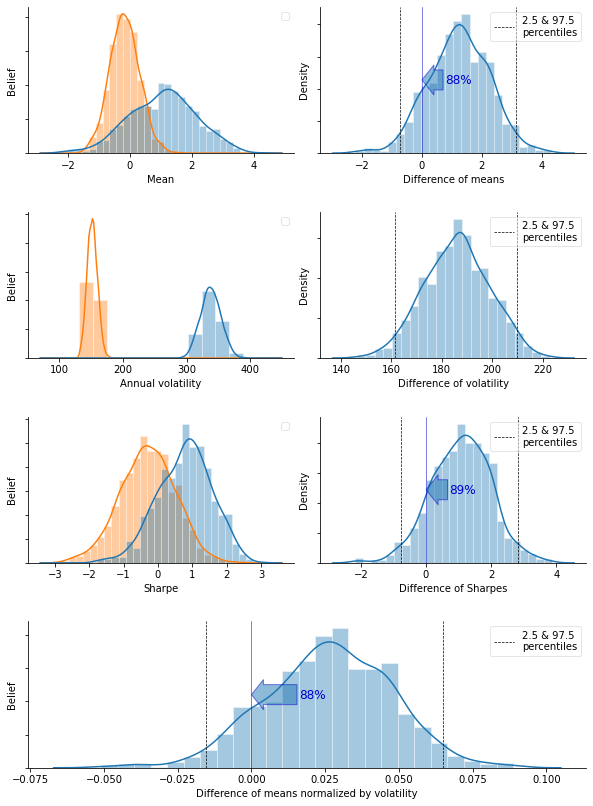

time: 43.6 s (started: 2023-02-28 11:32:20 +09:00)


In [169]:
bayesian_estimate(df, chains=1, draws=1000, tune=100, plot_trace=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [std_b2, mean_b2, std_b1, mean_b1, nu_minus_two]


Sampling 1 chain for 100 tune and 1_000 draw iterations (100 + 1_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


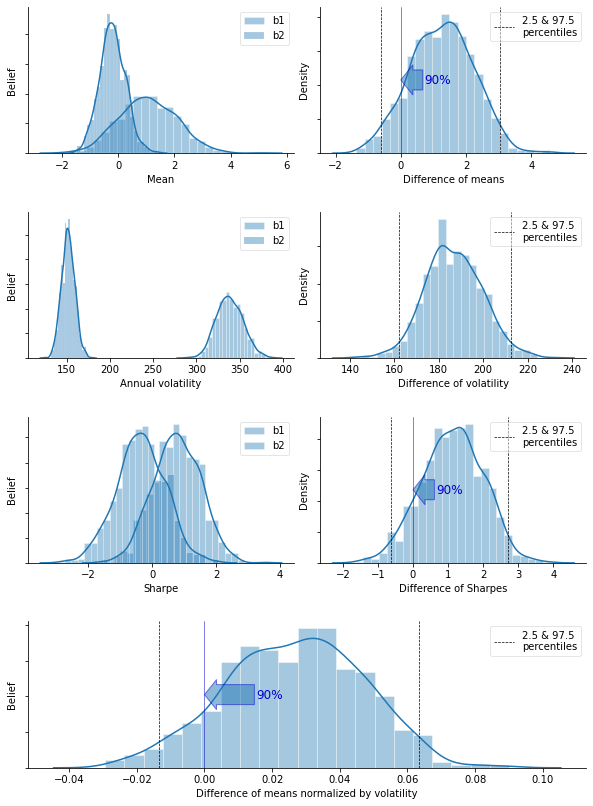

time: 46 s (started: 2023-02-28 10:53:26 +09:00)


In [127]:
testing = bayesian_estimate(df, chains=1, draws=1000, tune=100, plot_trace=False)
trace, groups = testing

In [134]:
#trace
#trace[f'mean_{g}']
groups

Index(['b1', 'b2'], dtype='object', name='scenario')

time: 5.88 ms (started: 2023-02-28 11:03:18 +09:00)


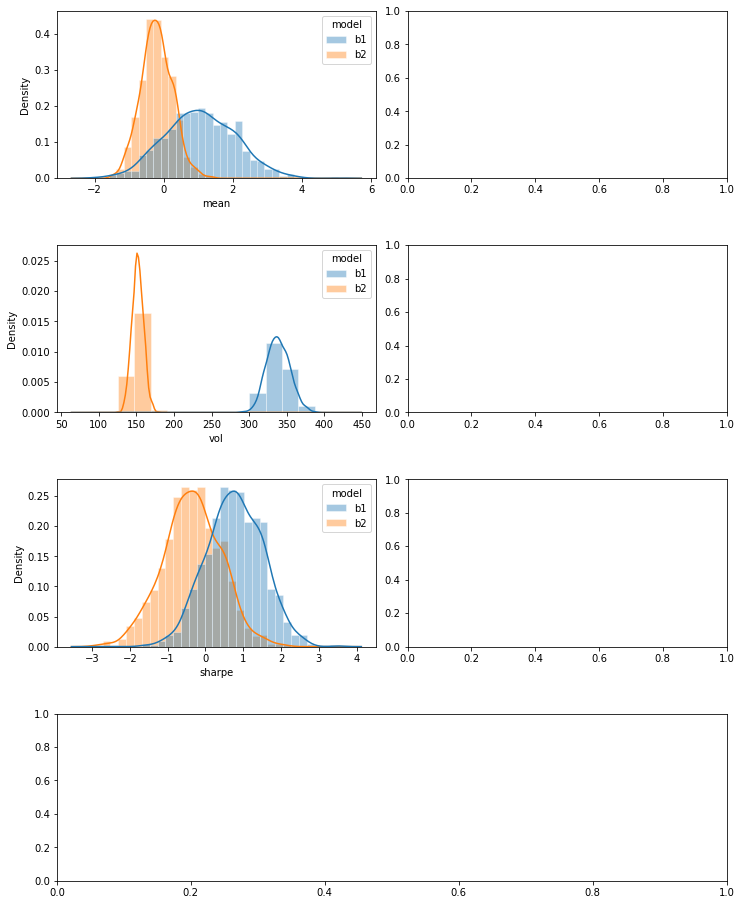

time: 4.43 s (started: 2023-02-28 11:29:45 +09:00)


In [166]:
#trace, groups, 
                        
burnin=0
figsize=(12, 16)
loc_legend='upper right'
                        
trace = trace[burnin:]
fig = plt.figure(figsize=figsize, constrained_layout=True)
num_groups = len(groups)
if num_groups == 2:
    cols = 2
else:
    cols = 1
gs = gridspec.GridSpec(4, cols, wspace=0.1, hspace=0.4)
axs = [plt.subplot(gs[i, j]) for i in [0, 1, 2] for j in [0, 1]]
axs.append(plt.subplot(gs[3, :]))
vl_style = {'ls':'--', 'lw':0.7, 'c':'black',}

kw_hist = dict(kde=True, stat="density", kde_kws=dict(cut=3), 
               alpha=.4, edgecolor=(1, 1, 1, .4))

def distplot_w_perc(trace, ax, p=2.5):
    #sns.distplot(trace, ax=ax)
    sns.histplot(trace, ax=ax, **kw_hist)
    ps = [stats.scoreatpercentile(trace, x) for x in [p, 100-p]]
    ax.axvline(ps[0],label='2.5 & 97.5\npercentiles', **vl_style)
    ax.axvline(ps[1],  **vl_style)
    display_credible(trace, ax, ref=0, alen=0.2*(ps[1]-ps[0]))

def display_credible(trace, ax, ref=0, alen=1):
    if trace.min() < ref < trace.max():
        c = 'mediumblue'
        ax.axvline(ref,  lw=0.5, c=c)
        x = 100 - stats.percentileofscore(trace, ref)
        a = np.mean(ax.get_ylim())
        ax.annotate(f'{x:.0f}%', 
                      xy=(ref, a), 
                      xycoords='data', 
                      xytext=(ref+alen, a), 
                      textcoords='data', 
                      ha='left', 
                      va='center',
                      fontsize='large', 
                      color=c,
                      arrowprops=dict(edgecolor=c, width=20, headwidth=30, alpha=0.5)
                   )
        
for i, v in enumerate(['mean', 'vol', 'sharpe']):
    dfs = [pd.DataFrame(trace[f'{v}_{g}'], columns=[v]).assign(model=g) for g in groups]
    sns.histplot(data=pd.concat(dfs).reset_index(), x=v, hue='model', ax=axs[i*num_groups], **kw_hist)

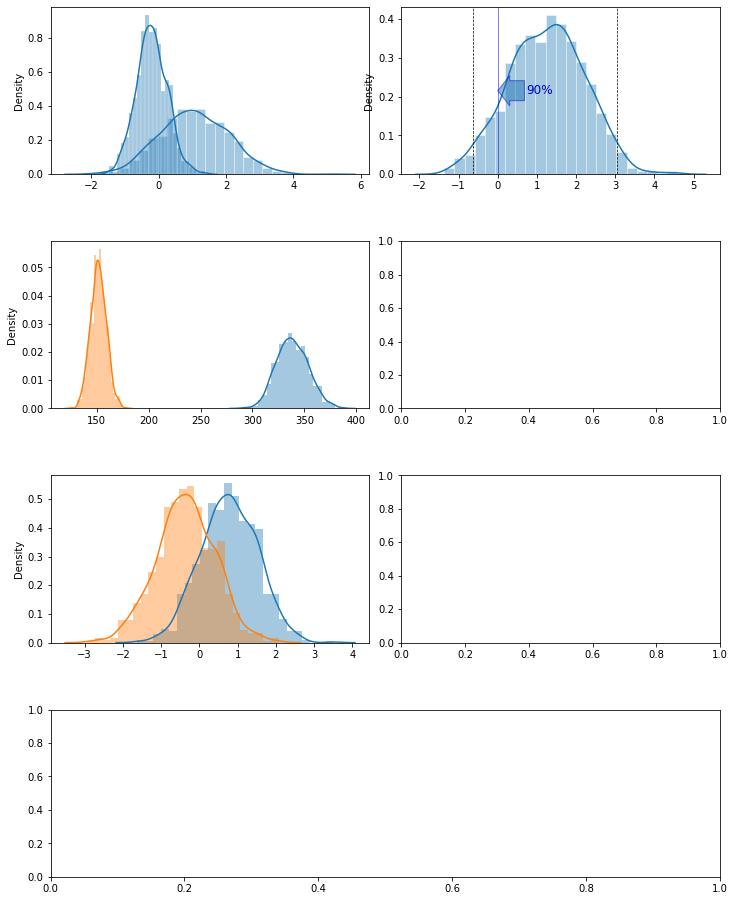

time: 4.24 s (started: 2023-02-28 11:06:44 +09:00)


In [ ]:
for i, g in enumerate(groups):
    sns.histplot(trace[f'mean_{g}'], ax=axs[0*num_groups], label=g, **kw_hist)
    sns.distplot(trace[f'vol_{g}'], ax=axs[1*num_groups], label=g)
    sns.distplot(trace[f'sharpe_{g}'], ax=axs[2*num_groups], label=g)

if len(groups) == 2:
    distplot_w_perc(trace['mean diff'], axs[1])

In [163]:
for v in ['mean', 'vol', 'sharpe']:
    dfs = [pd.DataFrame(trace[f'{v}_{g}'], columns=[v]).assign(model=g) for g in groups]
    sns.histplot(data=pd.concat(dfs).reset_index(), x=v, hue='model', ax=axs[0*num_groups], **kw_hist)

time: 1.42 s (started: 2023-02-28 11:27:58 +09:00)


<AxesSubplot:xlabel='mean', ylabel='Count'>

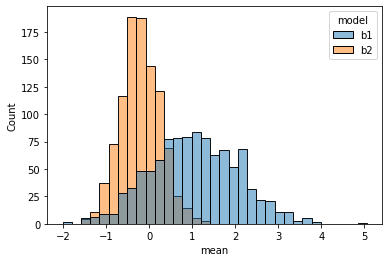

time: 1.78 s (started: 2023-02-28 11:23:32 +09:00)


In [160]:
dfs = [pd.DataFrame(trace[f'mean_{x}'], columns=['mean']).assign(model=x) for x in groups]
sns.histplot(data=pd.concat(dfs).reset_index(), x='mean', hue='model')

In [146]:
pd.concat(dfs)

,mean,model
0,0.762976,b1
1,0.552855,b1
2,0.402604,b1
3,0.868688,b1
4,1.555742,b1
...,...,...
995,-0.210550,b2
996,-0.444083,b2
997,-0.343388,b2
998,-0.839984,b2


time: 30.6 ms (started: 2023-02-28 11:16:05 +09:00)


<AxesSubplot:xlabel='flipper_length_mm', ylabel='Count'>

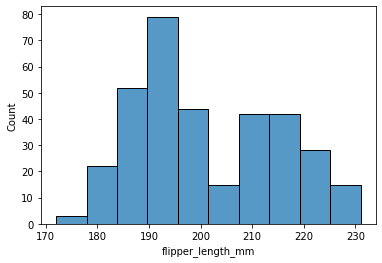

time: 1.43 s (started: 2023-02-28 11:17:17 +09:00)


In [148]:
penguins = sns.load_dataset("penguins")
sns.histplot(data=penguins, x="flipper_length_mm")

In [149]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


time: 58.6 ms (started: 2023-02-28 11:17:22 +09:00)


<AxesSubplot:xlabel='flipper_length_mm', ylabel='Count'>

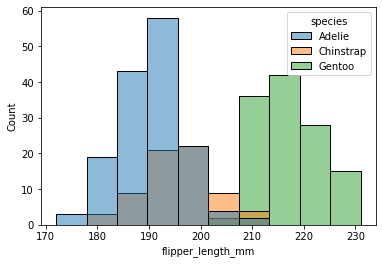

time: 785 ms (started: 2023-02-28 11:17:42 +09:00)


In [150]:
sns.histplot(data=penguins, x="flipper_length_mm", hue="species")

In [158]:
sns.histplot(data=pd.concat(dfs), hue='model')

ValueError: The following variable cannot be assigned with wide-form data: `hue`

time: 78.4 ms (started: 2023-02-28 11:22:09 +09:00)


In [157]:
pd.concat(dfs)

,mean,model
0,0.762976,b1
1,0.552855,b1
2,0.402604,b1
3,0.868688,b1
4,1.555742,b1
...,...,...
995,-0.210550,b2
996,-0.444083,b2
997,-0.343388,b2
998,-0.839984,b2


time: 31.7 ms (started: 2023-02-28 11:21:51 +09:00)


In [63]:
trace = trace['effect size']
stats.scoreatpercentile(trace, 2.5)

-0.013437554616702803

time: 14.1 ms (started: 2023-02-28 09:24:22 +09:00)


In [64]:
stats.percentileofscore(trace, 0)

10.75

time: 11 ms (started: 2023-02-28 09:24:22 +09:00)


In [65]:
trace.min(), trace.max()

(-0.039860620739489615, 0.08769541086015657)

time: 11 ms (started: 2023-02-28 09:24:24 +09:00)


In [67]:
len(trace)

2000

time: 13.8 ms (started: 2023-02-28 09:25:35 +09:00)


In [55]:
stats.percentileofscore([1, 2, 3, 4], 0)


0.0

time: 11.4 ms (started: 2023-02-28 08:57:37 +09:00)


In [ ]:
def calc_rank(trace, ax, ref=0, vl_style):
    if trace.min() < ref < trace.max():
        ax.axvline(ref,  **vl_style)
        x = stats.percentileofscore(trace, ref)
        ax.annotate(f'{x:.0f}', 
                      xy=(x, 0), 
                      xycoords='data', 
                      xytext=(5, 10), 
                      textcoords='offset points', 
                      #rotation=90, 
                      va='bottom', 
                      fontsize='large', 
                      color='#AA0022')
    return ax
        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_b2, mean_b2, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 2_500 tune and 10_000 draw iterations (10_000 + 40_000 draws total) took 427 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


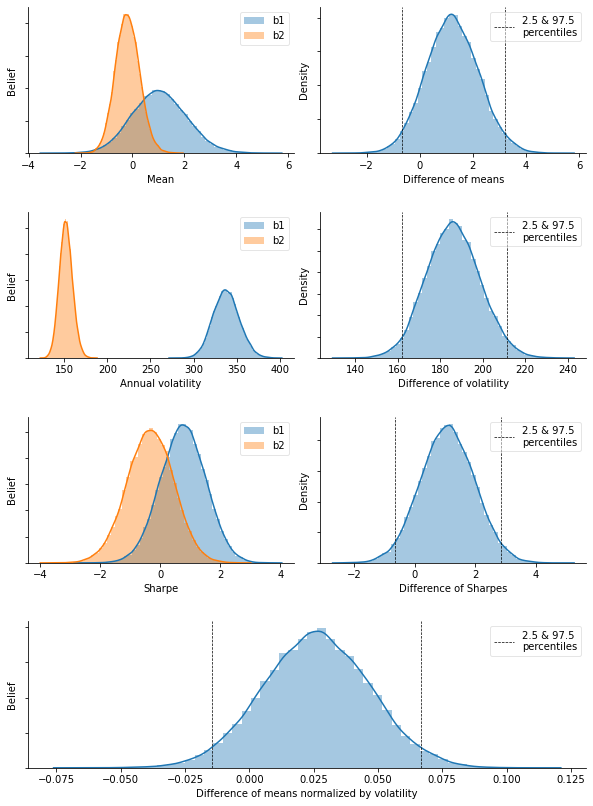

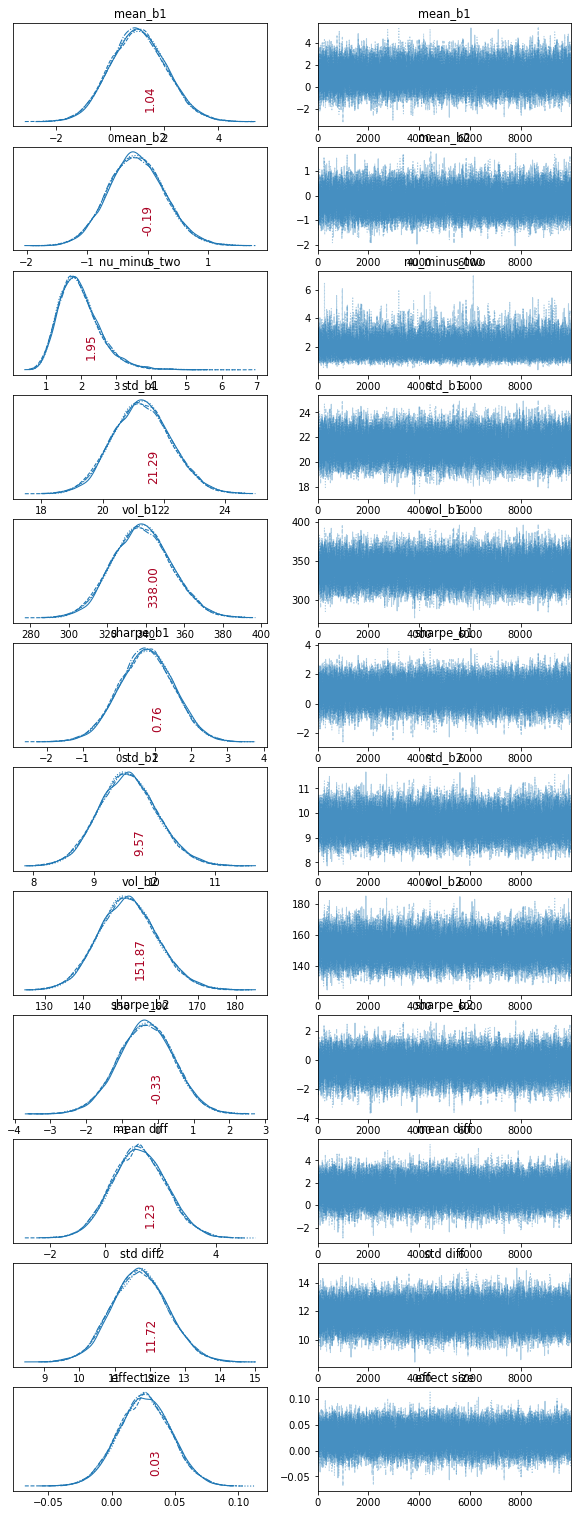

time: 10min 7s (started: 2023-02-28 08:12:14 +09:00)


In [38]:
bayesian_estimate(df)

In [39]:
df = df_compare.loc[df_compare.scenario.isin(['b1','t1a'])].reset_index().set_index(['scenario', 'start']).squeeze()

time: 12.9 ms (started: 2023-02-28 08:22:21 +09:00)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1a, mean_t1a, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 2_500 tune and 10_000 draw iterations (10_000 + 40_000 draws total) took 564 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


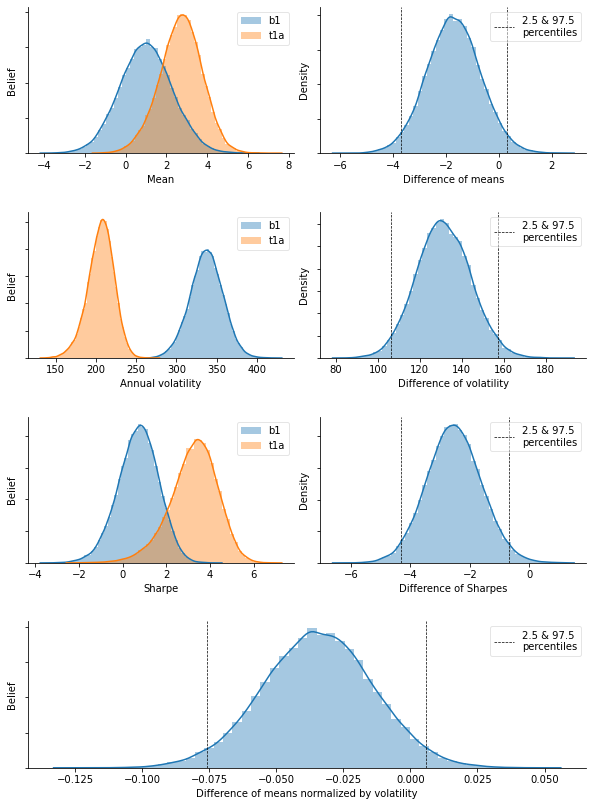

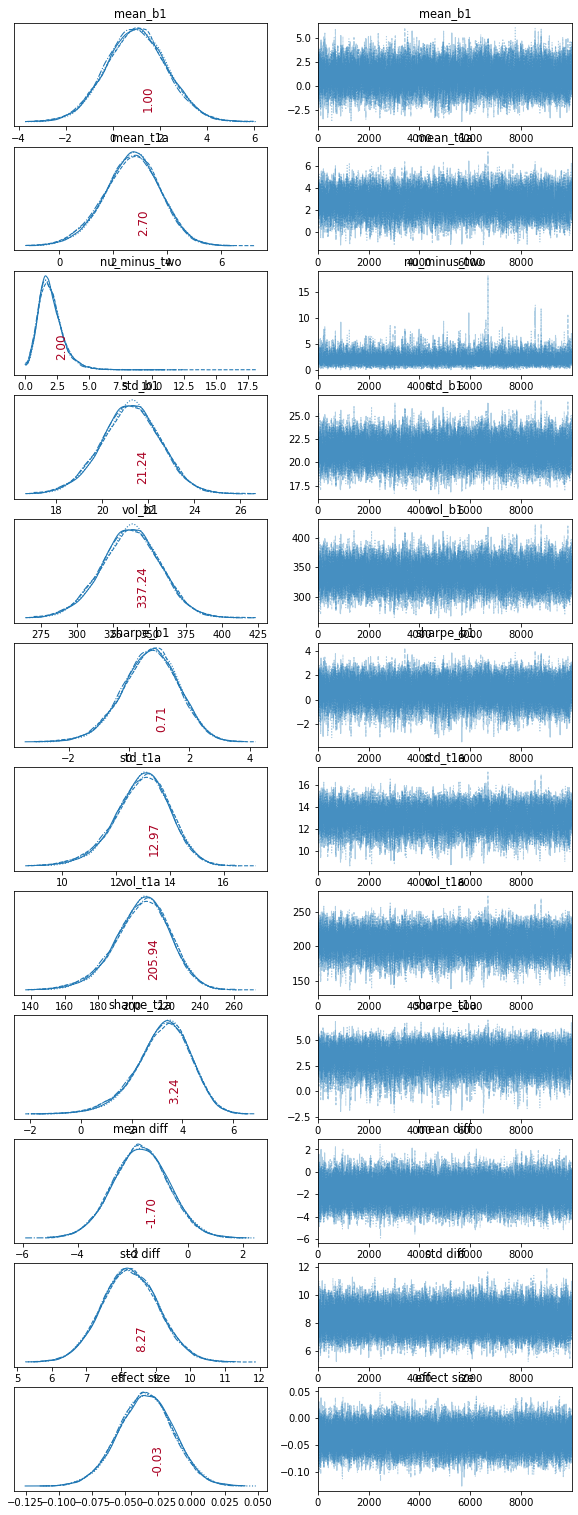

time: 12min 27s (started: 2023-02-28 08:22:21 +09:00)


In [40]:
bayesian_estimate(df)